In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import os
import joblib
# import ffmpeg
import matplotlib.pyplot as plt
import librosa
import librosa.display
# from pydub import AudioSegment as AS
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.utils import Sequence
import keras
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import sys
import h5py
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input,Dense, Conv2D, Flatten, MaxPooling2D, Dropout,\
    BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D, AveragePooling2D
from keras.layers import Bidirectional, LSTM, Reshape
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
import dataframe_image as dfi
from keras.models import Sequential
from keras.layers import Input,Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Permute

In [2]:
BATCH_SIZE = 128
set_name = 'librosa_all_samples'
folder_name = 'Model1'

In [3]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('error')
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda_malloc_async
Num GPUs Available:  1


In [4]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [5]:
ohe = joblib.load(f'{set_name}_ohe.joblib')

In [6]:
all_samples_train_df = pd.read_pickle(f'{set_name}_train.pkl')
all_samples_train_df = all_samples_train_df.rename(columns={'masked_features': 'features'})
X_train = np.stack([np.array(val, dtype = np.float32) for val in all_samples_train_df['features'].values], axis=0)
y_train = np.stack([np.array(val, dtype = np.float32) for val in all_samples_train_df['label'].values], axis=0)
del all_samples_train_df

In [7]:
all_samples_valid_df = pd.read_pickle(f'{set_name}_valid.pkl')
X_valid = np.stack([np.array(val, dtype = np.float32) for val in all_samples_valid_df['features'].values], axis=0)
y_valid = np.stack([np.array(val, dtype = np.float32) for val in all_samples_valid_df['label'].values], axis=0)
del all_samples_valid_df

In [8]:
all_samples_test_df = pd.read_pickle(f'{set_name}_test.pkl')
X_test = np.stack([np.array(val, dtype = np.float32) for val in all_samples_test_df['features'].values], axis=0)
y_test = np.stack([np.array(val, dtype = np.float32) for val in all_samples_test_df['label'].values], axis=0)
del all_samples_test_df

In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_valid = (X_valid - mean)/std
X_test = (X_test - mean)/std

# X_train = np.swapaxes(X_train,1,2)
# X_valid = np.swapaxes(X_valid,1,2)
# X_test = np.swapaxes(X_test,1,2)

In [10]:
train_gen = DataGenerator(X_train, y_train, BATCH_SIZE)
valid_gen = DataGenerator(X_valid, y_valid, BATCH_SIZE)
test_gen = DataGenerator(X_test, y_test, BATCH_SIZE)

In [11]:
X_train.shape

(9573, 128, 308)

In [12]:
def build_model1(nr_labels):
    model = Sequential()
    model.add(Input(shape=(128, 308)))
    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True, dropout=0.1))
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax'))
    return model

In [13]:
def build_model2(nr_labels):
    model = Sequential()
#     model.add(Permute((2, 1), input_shape=(128, 308)))
    model.add(LSTM(64, return_sequences = True, input_shape=(128, 308)))
    model.add(LSTM(64))
    model.add(Dense(7, activation = 'softmax'))
    return model

In [14]:
def build_model3(nr_labels):
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(128, 308)))
    model.add(Conv1D(32, kernel_size=5, padding='same',strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())
    model.add(Dropout(0.1))
    
    model.add(Conv1D(32, kernel_size=5, padding='same',strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())
    model.add(Dropout(0.1))
    
    model.add(Conv1D(32, kernel_size=5, padding='same',strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())
    model.add(Dropout(0.1))
    
    model.add(Conv1D(32, kernel_size=5, padding='same',strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())
    model.add(Dropout(0.1)) 
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())   
    
    
    model.add(Dense(7, activation='softmax'))
    return model

In [15]:
def build_model4(nr_labels):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu', input_shape = (20, 308, 1)))
    model.add(BatchNormalization())
    model.add(AveragePooling2D())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
#     model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [16]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=4, min_lr=0.0001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# checkpoint_path = 
# mcp_save = ModelCheckpoint(
#     f'E:/Dissertation/{set_name}_best_weights.hdf5',
#     save_best_only=True,
#     monitor='val_accuracy',
#     mode='max'
# )

In [17]:
def plot_hist_metrics(history):
    loss_hist = pd.DataFrame()
    loss_hist['training'] = history.history['loss']
    loss_hist['validation'] = history.history['val_loss']
    loss_hist.index = range(1, len(loss_hist)+1)
    ax = sns.lineplot(data=loss_hist)
    ax.set(xlabel='epochs', ylabel='loss', title='Loss',  ylim=(0, None))
    plt.savefig(f'{folder_name}/loss.png')
    plt.show()
    
    
    acc_hist = pd.DataFrame()
    acc_hist['training'] = history.history['accuracy']
    acc_hist['validation'] = history.history['val_accuracy']
    acc_hist.index = range(1, len(acc_hist)+1)
#     acc_hist.iloc[0] = [0, 0]
    ax = sns.lineplot(data=acc_hist)
    ax.set(xlabel='epochs', ylabel='accuracy', title='Accuracy', ylim=(0, 1))
    plt.savefig(f'{folder_name}/accuracy.png')
    plt.show()
    print("Validation accuracy: ", history.history['val_accuracy'][-1])
    
    
def get_predictions_df(filename, model, encoder, test_gen, y_test):
#     all_samples_test_df = pd.read_pickle(filename)
#     X_test = np.array([np.array(val) for val in all_samples_test_df['features'].values])
#     y_test = np.array([np.array(val) for val in all_samples_test_df['label'].values])
#     del all_samples_test_df
#     test_gen = DataGenerator(X_test, y_test, BATCH_SIZE)
    
    test_predictions = model.predict(test_gen)
    test_predictions_decoded = ohe.inverse_transform(test_predictions)
    test_actual_labels = ohe.inverse_transform(y_test)
    test_df = pd.DataFrame()
    test_df['y_pred'] = test_predictions_decoded.flatten()
    test_df['y_true'] = test_actual_labels
    print("Test accuracy: ", model.evaluate(test_gen)[1])
    return test_df

def print_confusion_matrix(df, encoder):
    all_labels = encoder.categories_[0].tolist()
    cm = confusion_matrix(df.y_true, df.y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in all_labels],
                      columns = [i for i in all_labels])
    plt.figure(figsize = (12, 9))
    ax = sns.heatmap(df_cm, fmt = 'd', annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
    ax.set(xlabel='predicted', ylabel='actual')
    plt.xticks(rotation=40, ha='right')
    plt.savefig(f'{folder_name}/confusion_matrix.png')
    plt.show()
    return df_cm

def get_metrics(cm_df, ohe):
    def compute_metrics(cm_df, label):
        other_labels = [l for l in cm_df.columns.tolist() if l != label]
        tp = cm_df[label][cm_df.index == label].values.sum()
        fp = cm_df[label][cm_df.index != label].values.sum()
        fn = cm_df[other_labels][cm_df.index == label].values.sum()
        tn = cm_df[other_labels][cm_df.index != label].values.sum()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        metrics = {
            'class': label,
            'accuracy': (tp + tn) / (tp + fp + fn + tn),
            'precision': precision,
            'recall': recall,
            'f1_score': 2 * (precision * recall) / (precision + recall),
            'sensitivity': tp / (tp + fn),
            'specificity': fp / (fp + tn),
        }
        return metrics

    metrics_df = pd.DataFrame()
    for label in ohe.categories_[0]:
        df = pd.DataFrame(compute_metrics(cm_df=cm_df, label=label), index=[0])
        metrics_df = metrics_df.append(df)
    metrics_df = metrics_df.reset_index(drop=True)
#     metrics_df['sort'] = metrics_df['class'].apply(lambda x: x.split('_')[1])
#     metrics_df = metrics_df.sort_values('sort').reset_index(drop=True)
#     metrics_df = metrics_df.drop('sort', axis=1)
    
    aux_df = metrics_df.melt('class')
    ax = sns.catplot(data=aux_df, col='variable', y='value', x='class', kind='bar', palette="Paired", col_wrap=3)
    ax.set_xticklabels(rotation=40, ha='right')
    plt.savefig(f'{folder_name}/metrics.png')
    plt.show()
    return metrics_df


# Model 1

In [18]:
model1 = build_model1(y_train.shape[1])
model1.build()
model1.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 256)          236800    
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 256)          196864    
                                                                 
 batch_normalization (BatchN  (None, 128, 256)         1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 lstm (LSTM)                 (None, 128, 128)          197120    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                        

In [19]:
history1 = model1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[
        rlrop,
        es,
    ]
)
print('Training done...moving to next set')

Epoch 1/100
75/75 [==============================] - 10s 71ms/step - loss: 1.8382 - accuracy: 0.2612 - val_loss: 1.7884 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 5s 60ms/step - loss: 1.6495 - accuracy: 0.3322 - val_loss: 1.6268 - val_accuracy: 0.3442 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 5s 60ms/step - loss: 1.5624 - accuracy: 0.3641 - val_loss: 1.5650 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 5s 60ms/step - loss: 1.4848 - accuracy: 0.4043 - val_loss: 1.4428 - val_accuracy: 0.4261 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 5s 61ms/step - loss: 1.4265 - accuracy: 0.4246 - val_loss: 1.4154 - val_accuracy: 0.4269 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 5s 61ms/step - loss: 1.3764 - accuracy: 0.4408 - val_loss: 1.3639 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 5s 61ms/step - l

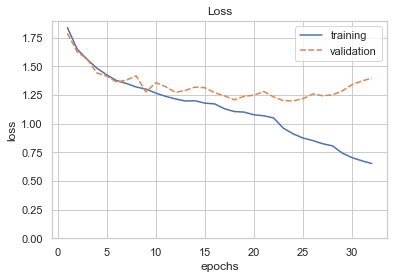

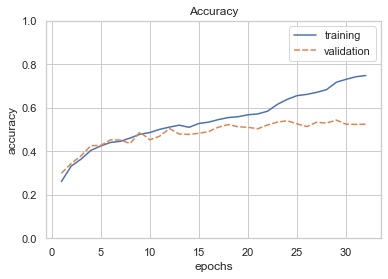

Validation accuracy:  0.5246449708938599
10/10 [==============================] - 0s 29ms/step - loss: 1.2430 - accuracy: 0.5272
Test accuracy:  0.5271512269973755


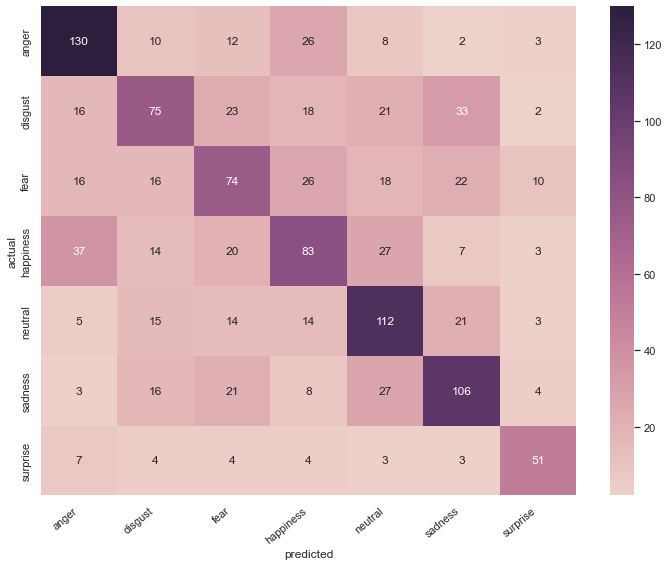

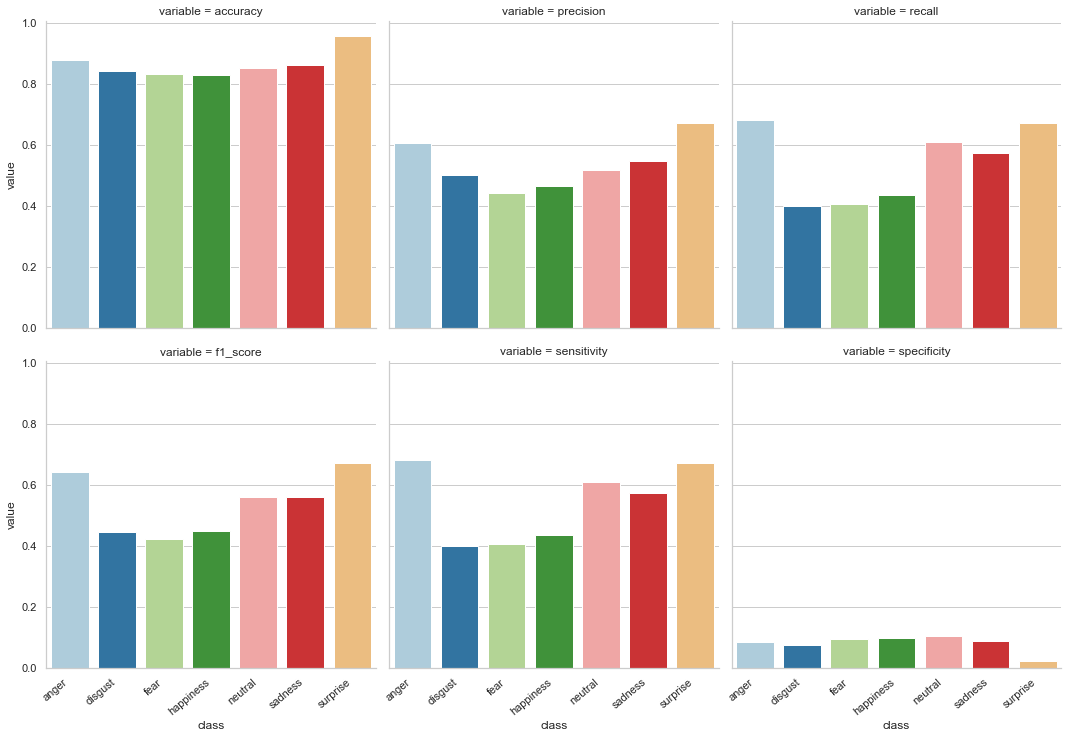

,class,accuracy,precision,recall,f1_score,sensitivity,specificity
0,anger,0.878864,0.607477,0.680628,0.641975,0.680628,0.083499
1,disgust,0.842941,0.500000,0.398936,0.443787,0.398936,0.074331
2,fear,0.831245,0.440476,0.406593,0.422857,0.406593,0.092611
3,happiness,0.829574,0.463687,0.434555,0.448649,0.434555,0.095427
4,neutral,0.852966,0.518519,0.608696,0.560000,0.608696,0.102665
5,sadness,0.860485,0.546392,0.572973,0.559367,0.572973,0.086957
6,surprise,0.958229,0.671053,0.671053,0.671053,0.671053,0.022302


In [20]:
sns.set_theme(style="whitegrid")
test_pickle = f'{set_name}_test.pkl'
plot_hist_metrics(history1)
test_df = get_predictions_df(filename=test_pickle, model=model1, encoder=ohe, test_gen = test_gen, y_test = y_test)
cm_df = print_confusion_matrix(df=test_df, encoder=ohe)
metrics_df = get_metrics(cm_df=cm_df, ohe=ohe)

dfi.export(metrics_df, f'{folder_name}/dataframe.png')
metrics_df

# Model 2

In [21]:
model2 = build_model2(y_train.shape[1])
model2.build()
model2.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 64)           95488     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 128,967
Trainable params: 128,967
Non-trainable params: 0
_________________________________________________________________


In [22]:
history2 = model2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[
        rlrop,
        es,
    ]
)
print('Training done...moving to next set')

Epoch 1/100
75/75 [==============================] - 6s 42ms/step - loss: 1.6898 - accuracy: 0.3062 - val_loss: 1.5662 - val_accuracy: 0.3826 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 2s 31ms/step - loss: 1.5176 - accuracy: 0.3903 - val_loss: 1.4894 - val_accuracy: 0.3993 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 2s 32ms/step - loss: 1.4372 - accuracy: 0.4240 - val_loss: 1.4299 - val_accuracy: 0.4327 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 2s 32ms/step - loss: 1.3781 - accuracy: 0.4472 - val_loss: 1.3885 - val_accuracy: 0.4369 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 2s 32ms/step - loss: 1.3146 - accuracy: 0.4797 - val_loss: 1.3499 - val_accuracy: 0.4637 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 2s 32ms/step - loss: 1.2790 - accuracy: 0.4913 - val_loss: 1.3204 - val_accuracy: 0.4645 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 2s 32ms/step - lo

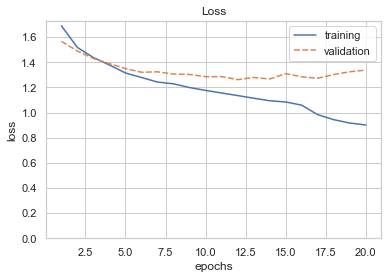

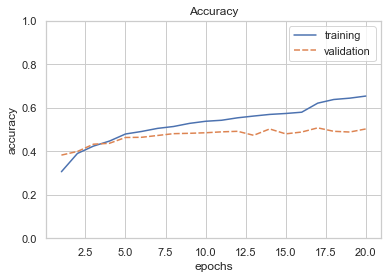

Validation accuracy:  0.5029239654541016
10/10 [==============================] - 0s 14ms/step - loss: 1.3088 - accuracy: 0.5029
Test accuracy:  0.5029239654541016


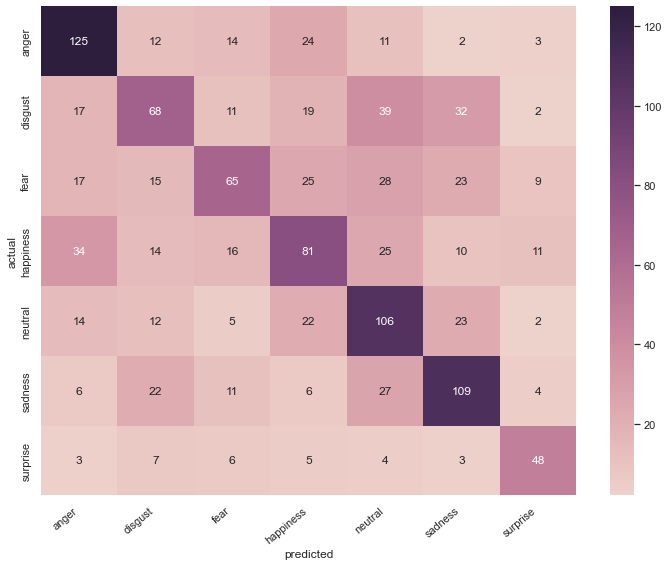

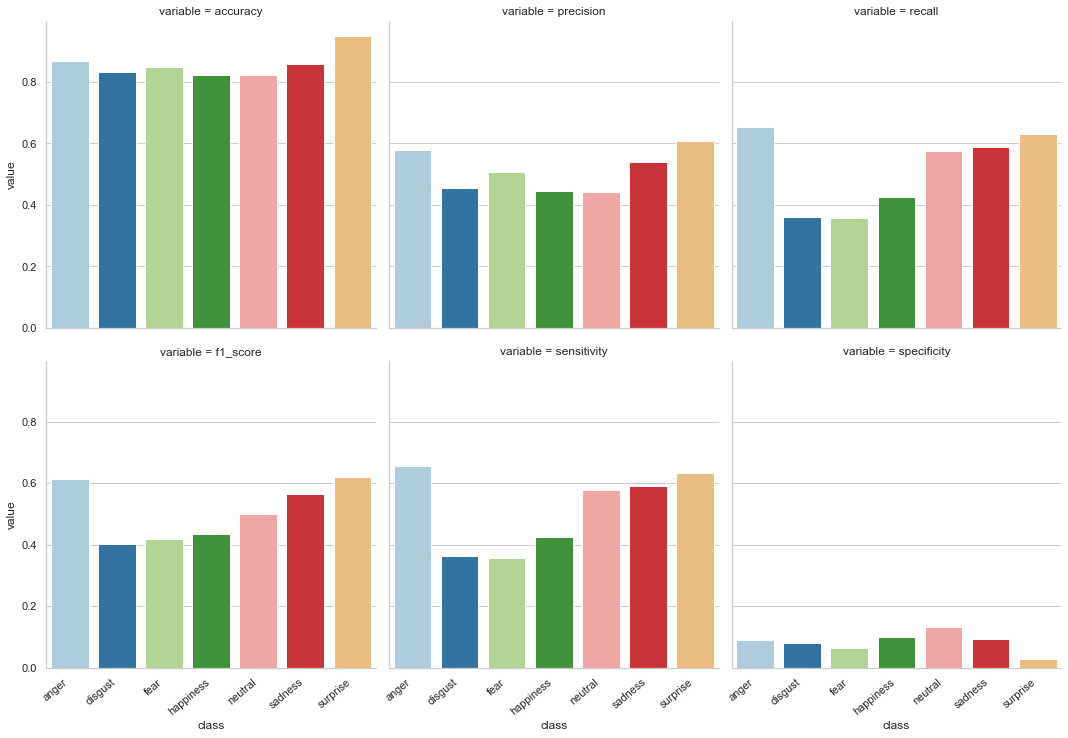

,class,accuracy,precision,recall,f1_score,sensitivity,specificity
0,anger,0.868839,0.578704,0.654450,0.614251,0.654450,0.090457
1,disgust,0.831245,0.453333,0.361702,0.402367,0.361702,0.081269
2,fear,0.849624,0.507812,0.357143,0.419355,0.357143,0.062069
3,happiness,0.823726,0.445055,0.424084,0.434316,0.424084,0.100398
4,neutral,0.822891,0.441667,0.576087,0.500000,0.576087,0.132280
5,sadness,0.858814,0.539604,0.589189,0.563307,0.589189,0.091897
6,surprise,0.950710,0.607595,0.631579,0.619355,0.631579,0.027654


In [23]:
folder_name = 'Model2'
sns.set_theme(style="whitegrid")
test_pickle = f'{set_name}_test.pkl'
plot_hist_metrics(history2)
test_df = get_predictions_df(filename=test_pickle, model=model2, encoder=ohe, test_gen = test_gen, y_test = y_test)
cm_df = print_confusion_matrix(df=test_df, encoder=ohe)
metrics_df = get_metrics(cm_df=cm_df, ohe=ohe)

dfi.export(metrics_df, f'{folder_name}/dataframe.png')
metrics_df

# Model 3

In [24]:
model3 = build_model3(y_train.shape[1])
model3.build()
model3.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 308, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 308, 32)           20512     
                                                                 
 batch_normalization_3 (Batc  (None, 308, 32)          128       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 154, 32)          0         
 ooling1D)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 154, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 154, 32)          

In [25]:
history3 = model3.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[
        rlrop,
        es,
    ]
)
print('Training done...moving to next set')

Epoch 1/100
75/75 [==============================] - 5s 38ms/step - loss: 1.7755 - accuracy: 0.3541 - val_loss: 1.6273 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 2s 26ms/step - loss: 1.3426 - accuracy: 0.4888 - val_loss: 1.2190 - val_accuracy: 0.5330 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 2s 25ms/step - loss: 1.2240 - accuracy: 0.5259 - val_loss: 1.1206 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 2s 26ms/step - loss: 1.1556 - accuracy: 0.5487 - val_loss: 1.0717 - val_accuracy: 0.5748 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 2s 25ms/step - loss: 1.1011 - accuracy: 0.5729 - val_loss: 1.0548 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 2s 26ms/step - loss: 1.0697 - accuracy: 0.5807 - val_loss: 1.0095 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 2s 26ms/step - lo

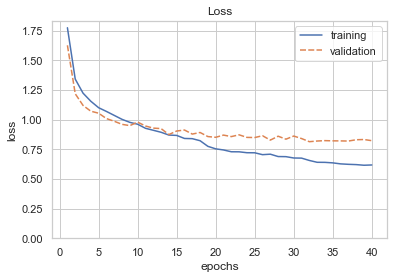

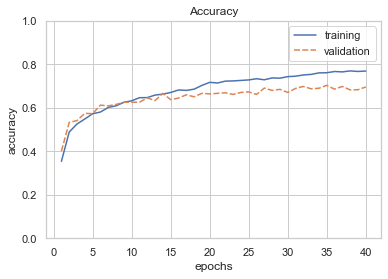

Validation accuracy:  0.6959064602851868
10/10 [==============================] - 0s 13ms/step - loss: 0.8902 - accuracy: 0.6642
Test accuracy:  0.664160430431366


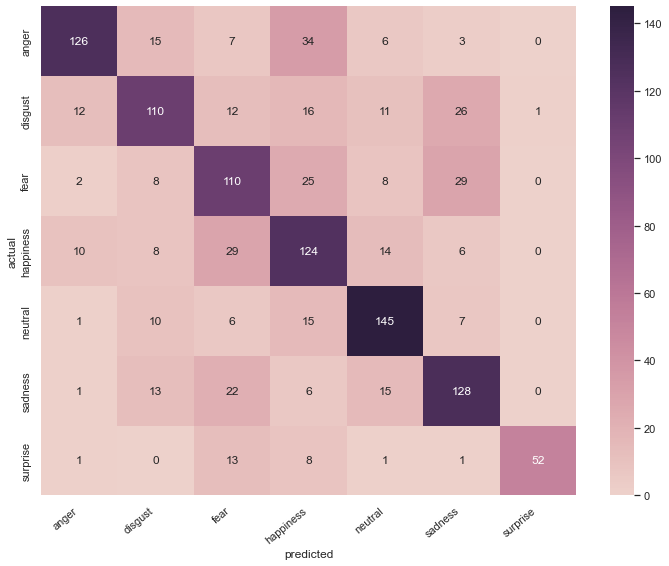

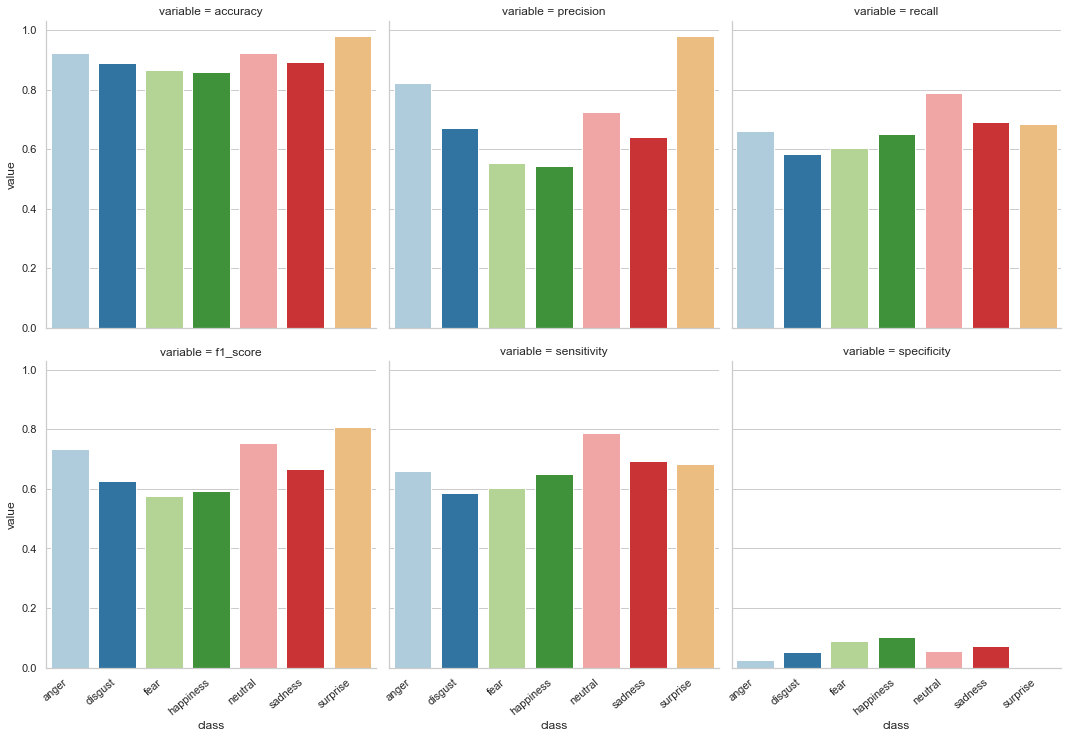

,class,accuracy,precision,recall,f1_score,sensitivity,specificity
0,anger,0.923141,0.823529,0.659686,0.732558,0.659686,0.026839
1,disgust,0.889724,0.670732,0.585106,0.625000,0.585106,0.053518
2,fear,0.865497,0.552764,0.604396,0.577428,0.604396,0.087685
3,happiness,0.857143,0.543860,0.649215,0.591885,0.649215,0.103380
4,neutral,0.921470,0.725000,0.788043,0.755208,0.788043,0.054294
5,sadness,0.892231,0.640000,0.691892,0.664935,0.691892,0.071146
6,surprise,0.979114,0.981132,0.684211,0.806202,0.684211,0.000892


In [26]:
folder_name = 'Model3'
sns.set_theme(style="whitegrid")
test_pickle = f'{set_name}_test.pkl'
plot_hist_metrics(history3)
test_df = get_predictions_df(filename=test_pickle, model=model3, encoder=ohe, test_gen = test_gen, y_test = y_test)
cm_df = print_confusion_matrix(df=test_df, encoder=ohe)
metrics_df = get_metrics(cm_df=cm_df, ohe=ohe)

dfi.export(metrics_df, f'{folder_name}/dataframe.png')
metrics_df